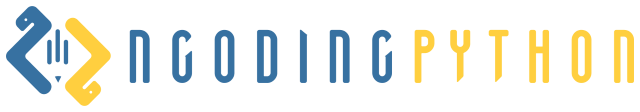

# Bangun, Latih dan Deploy Model SMS Spam

Author : Afif A. Iskandar ([@afif.ai](https://youtube.com/NgodingPython))



Dalam notebook ini, Saya akan menunjukkan bagaimana menggunakan Amazon SageMaker untuk membangun, melatih dan mendeploy model ML berbasis Scikit-Learn (Naive Bayes). Informasi lebih lanjut tentang Scikit-Learn dapat ditemukan di sini https://scikit-learn.org/stable/index.html.

Dalam notebook ini saya menggunakan dataset SMS Spam Bahasa Indonesia yang dapat ditemukan di https://yudiwbs.wordpress.com/2018/08/05/dataset-klasifikasi-bahasa-indonesia-sms-spam-klasifikasi-teks-dengan-scikit-learn/

**Notebook ini bertujuan untuk demonstrasi, pastikan untuk melakukan pengujian yang sesuai jika Anda menggunakan kode ini untuk kasus penggunaan Anda sendiri!**

In [1]:
# Import library yang dibutuhkan
import os
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session

In [2]:
bucket_name = 'spamclassification' 
my_region = boto3.session.Session().region_name
print(my_region)

us-east-1


In [3]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket berhasil dibuat')
except Exception as e:
    print('S3 error: ',e)

S3 bucket berhasil dibuat


In [4]:
# definisikan path output tempat menyimpan model yang sudah ditrain
prefix = 'model-spam'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://spamclassification/model-spam/output


## Persiapan Dataset

Pada tahap ini, kita akan mengunduh data dari repositori Github. Setelah itu, kita akan membagi dataset menjadi data training dan data testing dengan menggunakan library scikit-learn. Setelah kita mempunyai data yang sudah terbagi, selanjutnya kita akan menyimpan kedua dataset tersebut dalam format csv dan mengunggahnya ke dalam bucket Amazon S3. Dengan begitu, data dapat disimpan dan diakses dari berbagai lokasi dengan mudah.

In [5]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://github.com/afifai/Tutorial-AWS-SageMaker/raw/main/dataset_sms_spam_v1.csv", "dataset_sms_spam_v1.csv")
    print('[INFO] Sukses mendownload dataset')
except Exception as e:
    print('Download data eror: ',e)

try:
    df = pd.read_csv('./dataset_sms_spam_v1.csv')
    print('[INFO] Sukses load dataset')
except Exception as e:
    print('Load data error: ',e)

df.head()

[INFO] Sukses mendownload dataset
[INFO] Sukses load dataset


,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [6]:
# Ubah label supaya lebih deskriptif
df.label = df.label.map({0:"SMS Biasa", 1:"SMS Penipuan", 2:"SMS Operator"})
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,SMS Operator
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,SMS Operator
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",SMS Operator
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",SMS Operator
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,SMS Operator


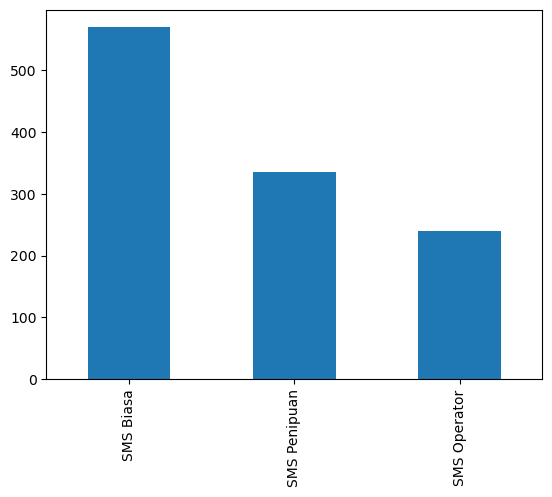

In [7]:
# lihat distribusi kelas
import matplotlib.pyplot as plt
df.label.value_counts().plot(kind='bar');

In [8]:
# Split data menjadi data train dan test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.Teks, df.label, test_size=0.2)

In [9]:
# Simpan data train dan test dalam csv

trainX = pd.DataFrame(X_train)
trainX['label'] = y_train

testX = pd.DataFrame(X_test)
testX['label'] = y_test

trainX.to_csv("train.csv",index = False)
testX.to_csv("test.csv", index = False)

In [10]:
# Upload data ke S3. SageMaker akan mengambil data dari s3
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
trainpath = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
testpath = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

Buat script training model dari data yang telah displit diatas, lalu disimpan kedalam file `train.py`. Panduan detil dapat dilihat di https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#preparing-the-scikit-learn-training-script.

In [11]:
%%writefile train.py

import os
import argparse
import joblib
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

if __name__ == "__main__":
    print("[INFO] Ekstraksi Input Argumen")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--random_state", type=int, default=0)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")
    
    args, _ = parser.parse_known_args()
    
    print("Versi SKLEARN: ", sklearn.__version__)
    
    print("[INFO] Load Data")
    print()
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    X_train, y_train = train_df['Teks'], train_df['label']
    X_test, y_test = test_df['Teks'], test_df['label']
    
    print("[INFO] Training Model")
    model = make_pipeline(CountVectorizer(), MultinomialNB())
    model.fit(X_train, y_train)
    
    print("[INFO] Menyimpan Model")
    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model,model_path)
    print(f"Model disimpan di {model_path}\n")
    
    print("[INFO] Mengevaluasi Model")
    y_pred = model.predict(X_test)
    print("HASIL EVALUASI")
    print(classification_report(y_pred, y_test))
    

Writing train.py


In [12]:
# coba jalankan script untuk memastikan script berjalan dengan baik
! python train.py --model-dir ./ \
                   --train ./ \
                   --test ./ \

[INFO] Ekstraksi Input Argumen
Versi SKLEARN:  1.2.0
[INFO] Load Data

[INFO] Training Model
[INFO] Menyimpan Model
Model disimpan di ./model.joblib

[INFO] Mengevaluasi Model
HASIL EVALUASI
              precision    recall  f1-score   support

   SMS Biasa       0.92      1.00      0.96       108
SMS Operator       0.96      0.83      0.89        60
SMS Penipuan       0.95      0.93      0.94        61

    accuracy                           0.94       229
   macro avg       0.94      0.92      0.93       229
weighted avg       0.94      0.94      0.94       229



### Latih Model dengan SageMaker menggunakan Python SDK

Pada potongan sel kode ini, kita akan menggunakan library SKLearn dari Amazon SageMaker untuk mengatur dan menjalankan pelatihan model machine learning dari script `train.py` yang sudah dibuat sebelumnya. Kita akan menentukan berbagai konfigurasi seperti jumlah instance yang akan digunakan, jenis instance, versi framework, dan nama `job` yang akan digunakan untuk identifikasi pada AWS console. Selain itu, kita juga akan menggunakan instance Spot untuk meminimalkan biaya penggunaan instance. Setelah konfigurasi selesai, kita akan menjalankan pelatihan model dengan memanggil objek SKLearn yang telah kita atur.

In [13]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="train.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.large",
  framework_version=FRAMEWORK_VERSION,
    base_job_name="NB-custom-sklearn",
    use_spot_instances = True,
    max_wait = 7200,
    max_run = 3600
)

In [14]:
# latih model
sklearn_estimator.fit({'train': trainpath,'test': testpath})

INFO:sagemaker:Creating training-job with name: NB-custom-sklearn-2023-03-18-00-20-52-730


2023-03-18 00:20:53 Starting - Starting the training job...
2023-03-18 00:21:08 Starting - Preparing the instances for training......
2023-03-18 00:21:55 Downloading - Downloading input data..2023-03-18 00:22:37,120 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-03-18 00:22:37,123 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-18 00:22:37,163 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-03-18 00:22:37,311 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-18 00:22:37,321 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-18 00:22:37,331 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-18 00:22:37,339 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
 

### Simpan Artifact Model

In [16]:
sm_boto3 = boto3.client("sagemaker")

sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)


2023-03-18 00:22:52 Starting - Preparing the instances for training
2023-03-18 00:22:52 Downloading - Downloading input data
2023-03-18 00:22:52 Training - Training image download completed. Training in progress.
2023-03-18 00:22:52 Uploading - Uploading generated training model
2023-03-18 00:22:52 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-974985730839/NB-custom-sklearn-2023-03-18-00-20-52-730/output/model.tar.gz


### Deploy Model

`Estimator` dapat langsung di-deploy setelah pelatihan data dengan menggunakan `estimator.deploy()`, namun di sini kami menunjukkan proses yang lebih ekstensif dalam membuat model dari *artifact* s3, yang dapat digunakan untuk men-deploy model yang dilatih di *session* yang berbeda atau bahkan di luar SageMaker.

In [17]:
from sagemaker.sklearn.model import SKLearnModel
from time import gmtime, strftime

model_name = "spam-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model = SKLearnModel(
    name =  model_name,
    model_data=artifact,
    role=get_execution_role(),
    entry_point="train.py",
    framework_version=FRAMEWORK_VERSION,
)

In [20]:

endpoint_name = "spam-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.large",
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: spam-sklearn-model-2023-03-18-00-26-31


EndpointName=spam-sklearn-model-2023-03-18-00-30-36


INFO:sagemaker:Creating endpoint-config with name spam-sklearn-model-2023-03-18-00-30-36
INFO:sagemaker:Creating endpoint with name spam-sklearn-model-2023-03-18-00-30-36


-----!

### Inference

In [21]:
# menggunakan SDK Python

sms_baru = "Kuota gratis, hanya untukmu"

print(predictor.predict([sms_baru]))

['SMS Operator']


In [24]:
# menggunakan npy serialization

from io import BytesIO
import numpy as np

runtime = boto3.client("sagemaker-runtime")
# Serialise numpy ndarray as bytes
buffer = BytesIO()
# Assuming testX is a data frame
np.save(buffer, [sms_baru])

response = runtime.invoke_endpoint(
    EndpointName=predictor.endpoint, Body=buffer.getvalue(), ContentType="application/x-npy"
)

print(eval(response["Body"].read().decode())[0])

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


SMS Operator


### Hapus Endpoint

Jangan lupa hapus endpoint setelah selesai bereksperimen

In [25]:

sm_boto3.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '92cde9db-ab9d-4abc-9850-0e32eaf9b445',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '92cde9db-ab9d-4abc-9850-0e32eaf9b445',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 18 Mar 2023 00:35:58 GMT'},
  'RetryAttempts': 0}}